# 데이터셋 불러오기

In [1]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# IMA이미지를 불러오는 라이브러리
import pydicom

import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [3.0, 3.0]
import seaborn as sns
import torch.nn as nn

In [4]:
root = '/content/drive/MyDrive'

In [5]:
import glob

L_list = glob.glob(f'{root}/mayo2016/*')
L_list = [path.split('/')[-1] for path in L_list]
L_list.sort()
L_list

['L067',
 'L096',
 'L109',
 'L143',
 'L192',
 'L286',
 'L291',
 'L310',
 'L333',
 'L506']

In [6]:
data_label = ['quarter_1mm', 'full_1mm']

In [7]:
def normlize(path):
  dicom_data = pydicom.dcmread(path)
  img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept
  mu, sd = (-500,500)
  scaled_img = (img - mu) / sd
  img = np.expand_dims(scaled_img, axis=0)

  return img # 1x512x512

In [8]:
def extract_patches(img, patch_size=55, interval=55):
  patches = []
  _, height, width = img.shape
  for y in range(0, height - patch_size + 1, interval):
    for x in range(0, width - patch_size + 1, interval):
      patch = img[:, y:y + patch_size, x:x + patch_size]
      patches.append(patch)
  patches = np.array(patches)
  return patches # patch수x1x55x55, numpy

In [9]:
import random
from scipy.ndimage import rotate, zoom

def augment_patches(X_patches, y_patches, p=0.5):
    X_augmented_patches, y_augmented_patches = [], []

    # random이 들어가기에, X랑 y를 동시에 넣어준다.
    for i, (X_patch, y_patch) in enumerate(zip(X_patches, y_patches)):
        # 원본 패치 추가
        X_augmented_patches.append(X_patch)
        y_augmented_patches.append(y_patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            X, y = rotate(X_patch, 90, axes=(1, 2), reshape=False), rotate(y_patch, 90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
            X, y = rotate(X_patch, -90, axes=(1, 2), reshape=False), rotate(y_patch, -90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 2. 수직 뒤집기
            X,y = np.flip(X_patch, axis=1),np.flip(y_patch, axis=1)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 3. 수평 뒤집기
            X,y = np.flip(X_patch, axis=2),np.flip(y_patch, axis=2)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)

    return np.array(X_augmented_patches), np.array(y_augmented_patches)

In [10]:
def patch_maker_W_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  X_augmented_patches, y_augmented_patches = augment_patches(X_patches, y_patches, p=0.5)
  return X_augmented_patches, y_augmented_patches

In [11]:
def patch_maker_WO_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  return X_patches, y_patches

In [12]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir
            y_dir_list += y_dir

        for X_dir, y_dir in tqdm(zip(X_dir_list, y_dir_list), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            for i in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[i]), torch.from_numpy(y_patches[i]) # torch로 넣어주자.
                self.image_pairs.append((X_patch, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)

        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = self.image_pairs[idx][0]
        y = self.image_pairs[idx][1]
        return X, y

In [13]:
# 파일 경로 설정
folder_name = f'{root}/dataset/'
train_path = folder_name+'train_dataset.pt'
val_path = folder_name+'val_dataset.pt'
test_path = folder_name+'test_dataset.pt'

# 데이터셋 불러오기
test_dataset = torch.load(test_path, weights_only=False)

In [14]:
batch_size = 16
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [15]:
len(test_loader)

6025

# 1. REDCNN

In [ ]:
!pwd

/root/code/unet/attention_spatial


In [ ]:
%cd /root/code/redcnn/base

/root/code/redcnn/base


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import torch
import torch.nn as nn

class RedCNN(nn.Module):
    def __init__(self):
        super(RedCNN, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()


    def forward(self, x):
        # 인코더 부분
        residual1 = x  # 첫 번째 잔차 저장
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x  # 두 번째 잔차 저장
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        residual3 = x  # 세 번째 잔차 저장
        x = self.relu(self.conv5(x))

        # 디코더 부분 (잔차를 더해줌)
        x = self.relu(self.deconv1(x)) + residual3  # 세 번째 잔차 연결
        x = self.relu(self.deconv2(x))
        x = self.relu((self.deconv3(x)) + residual2)  # 두 번째 잔차 연결
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1  # 첫 번째 잔차 연결

        return x

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load('red_cnn.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1005/6025 [00:21<01:43, 48.71it/s]

RMSE per interval: 0.0452, PSNR per interval: 27.74, SSIM per interval: 0.6797


Evaluating:  33%|███▎      | 2005/6025 [00:41<01:22, 48.81it/s]

RMSE per interval: 0.0427, PSNR per interval: 28.52, SSIM per interval: 0.6954


Evaluating:  50%|████▉     | 3005/6025 [01:01<01:01, 48.77it/s]

RMSE per interval: 0.0429, PSNR per interval: 28.67, SSIM per interval: 0.7047


Evaluating:  66%|██████▋   | 4005/6025 [01:22<00:41, 48.62it/s]

RMSE per interval: 0.0368, PSNR per interval: 29.65, SSIM per interval: 0.7310


Evaluating:  83%|████████▎ | 5005/6025 [01:42<00:20, 48.84it/s]

RMSE per interval: 0.0364, PSNR per interval: 29.74, SSIM per interval: 0.7090


Evaluating: 100%|█████████▉| 6005/6025 [02:02<00:00, 48.74it/s]

RMSE per interval: 0.0344, PSNR per interval: 30.47, SSIM per interval: 0.7518


Evaluating: 100%|██████████| 6025/6025 [02:03<00:00, 48.85it/s]

Average RMSE over all intervals: 0.039730


In [ ]:
len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [ ]:
rmse_list = loss_list
rmse_list

[0.04523577140271664,
 0.04268875097483397,
 0.04291353042889386,
 0.0367588047478348,
 0.03642563827056438,
 0.034357292416505515]

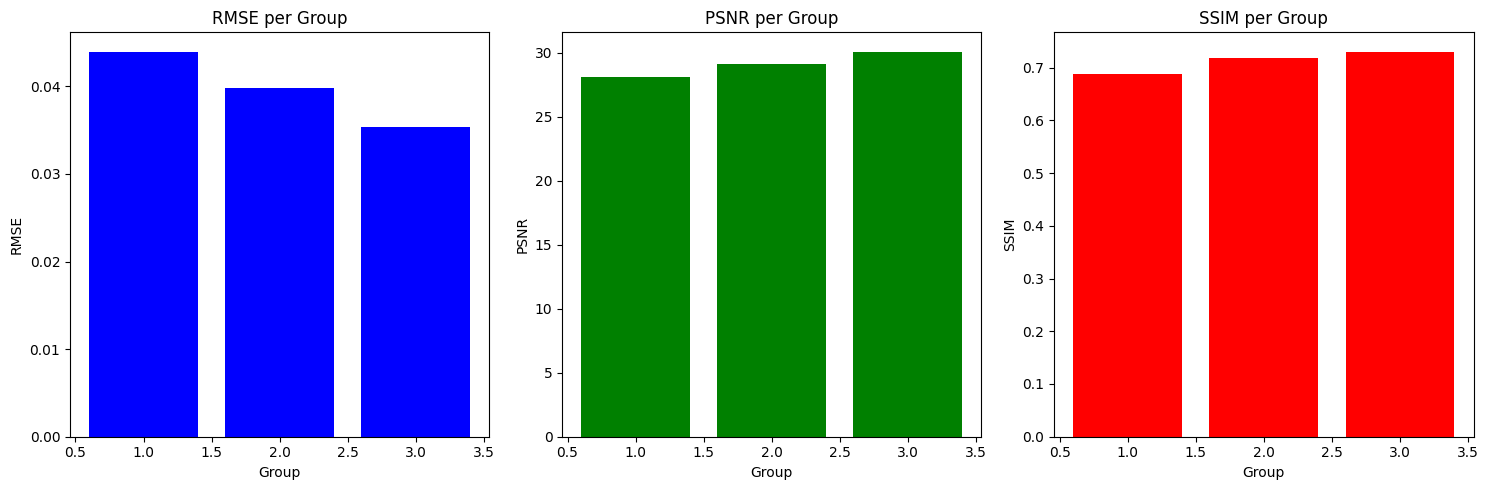

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 각 지표에 대해 6개씩 그룹화하여 평균값 계산
rmse_groups = [np.mean(rmse_list[0:2]), np.mean(rmse_list[2:4]), np.mean(rmse_list[4:6])]
psnr_groups = [np.mean(psnr_list[0:2]), np.mean(psnr_list[2:4]), np.mean(psnr_list[4:6])]
ssim_groups = [np.mean(ssim_list[0:2]), np.mean(ssim_list[2:4]), np.mean(ssim_list[4:6])]

# 그룹 인덱스 (1, 2, 3)
groups = [1, 2, 3]

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
axs[0].bar(groups, rmse_groups, color='b')
axs[0].set_title('RMSE per Group')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('RMSE')

# PSNR 그래프
axs[1].bar(groups, psnr_groups, color='g')
axs[1].set_title('PSNR per Group')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('PSNR')

# SSIM 그래프
axs[2].bar(groups, ssim_groups, color='r')
axs[2].set_title('SSIM per Group')
axs[2].set_xlabel('Group')
axs[2].set_ylabel('SSIM')

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

In [ ]:
# 평균(mean)과 표준편차(sd) 계산
rmse_mean = np.mean(rmse_list)
rmse_sd = np.std(rmse_list)

psnr_mean = np.mean(psnr_list)
psnr_sd = np.std(psnr_list)

ssim_mean = np.mean(ssim_list)
ssim_sd = np.std(ssim_list)

# 결과를 mean ± sd 형식으로 표현
rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# 결과 출력
print(f"RMSE: {rmse_result}")
print(f"PSNR: {psnr_result}")
print(f"SSIM: {ssim_result}")

RMSE: 0.0397 ± 0.0040
PSNR: 29.1317 ± 0.9085
SSIM: 0.7119 ± 0.0235


In [ ]:
import os
import numpy as np

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(file_names["loss"], loss_list)
np.save(file_names["psnr"], psnr_list)
np.save(file_names["ssim"], ssim_list)

print(f"Lists have been saved in the 'unet' folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")


Lists have been saved in the 'unet' folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


# 1-2. REDCNN with C.A.

In [16]:
!pwd

/content


In [17]:
%cd /content/drive/MyDrive/attention_channel

/content/drive/MyDrive/attention_channel


In [18]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
        self.last_attention = None  # 저장된 Attention 값을 위한 변수

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # 채널별 전역 평균 풀링
        y = self.avg_pool(x).view(batch, channels)
        y = self.fc(y).view(batch, channels, 1, 1)
        self.last_attention = y  # 계산된 Attention Weight 저장
        return x * y

In [20]:
class RedCNNWithChannelAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithChannelAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Attention Blocks (효율적 배치)
        self.attention2 = SEBlock(96)  # 중간 계층
        self.attention3 = SEBlock(96)  # 고수준 특징 계층

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.attention2(x)  # 중간 계층에 Attention
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.attention3(x)  # 최종 인코더 계층에 Attention

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [30]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithChannelAttention().to(device)
model.load_state_dict(torch.load('red_cnn_C_A.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1008/6025 [00:14<01:09, 71.71it/s]

RMSE per interval: 0.0463, PSNR per interval: 27.50, SSIM per interval: 0.6734


Evaluating:  33%|███▎      | 2008/6025 [00:28<00:55, 72.65it/s]

RMSE per interval: 0.0438, PSNR per interval: 28.24, SSIM per interval: 0.6897


Evaluating:  50%|████▉     | 3008/6025 [00:41<00:41, 73.15it/s]

RMSE per interval: 0.0443, PSNR per interval: 28.28, SSIM per interval: 0.6984


Evaluating:  67%|██████▋   | 4009/6025 [00:56<00:28, 69.87it/s]

RMSE per interval: 0.0378, PSNR per interval: 29.32, SSIM per interval: 0.7236


Evaluating:  83%|████████▎ | 5011/6025 [01:10<00:14, 68.10it/s]

RMSE per interval: 0.0376, PSNR per interval: 29.41, SSIM per interval: 0.7027


Evaluating: 100%|█████████▉| 6007/6025 [01:24<00:00, 71.35it/s]

RMSE per interval: 0.0356, PSNR per interval: 30.08, SSIM per interval: 0.7453


Evaluating: 100%|██████████| 6025/6025 [01:24<00:00, 71.25it/s]

Average RMSE over all intervals: 0.040910


In [31]:
len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [32]:
rmse_list = loss_list
rmse_list

[0.04633066806383431,
 0.04383786635100841,
 0.044337182939983906,
 0.037824757872149346,
 0.037551619643345475,
 0.0355773805398494]

In [33]:
!pwd

/content/drive/MyDrive/attention_channel


In [34]:
# 저장하는 코드

import pandas as pd

# 데이터프레임 생성
df = pd.DataFrame({
    "RMSE": loss_list,
    "PSNR": psnr_list,
    "SSIM": ssim_list
})

# CSV 파일 저장
csv_filename = f"{root}/attention_channel/results.csv"
df.to_csv(csv_filename, index=False)

print(f"저장 완료: {csv_filename}")

저장 완료: /content/drive/MyDrive/attention_channel/results.csv


In [39]:
# 불러오는 코드

import pandas as pd

# CSV 파일 불러오기
csv_filename = f"{root}/attention_channel/results.csv"
df = pd.read_csv(csv_filename)

# 불러온 데이터 출력
print(df,'\n')

# 개별 리스트로 변환
loss_list = df["RMSE"].tolist()
psnr_list = df["PSNR"].tolist()
ssim_list = df["SSIM"].tolist()

# 확인 출력
print("RMSE List:", loss_list)
print("PSNR List:", psnr_list)
print("SSIM List:", ssim_list)

       RMSE       PSNR      SSIM
0  0.046331  27.501560  0.673425
1  0.043838  28.235191  0.689721
2  0.044337  28.282834  0.698382
3  0.037825  29.323287  0.723607
4  0.037552  29.405523  0.702748
5  0.035577  30.082457  0.745334 

RMSE List: [0.0463306680638343, 0.0438378663510084, 0.0443371829399839, 0.0378247578721493, 0.0375516196433454, 0.0355773805398494]
PSNR List: [27.50156021453031, 28.23519090467294, 28.28283403701361, 29.323287006458195, 29.405523280656475, 30.082456628002458]
SSIM List: [0.6734251533485751, 0.6897214727155603, 0.6983818373312854, 0.7236065084315962, 0.702747545921852, 0.7453338743389388]


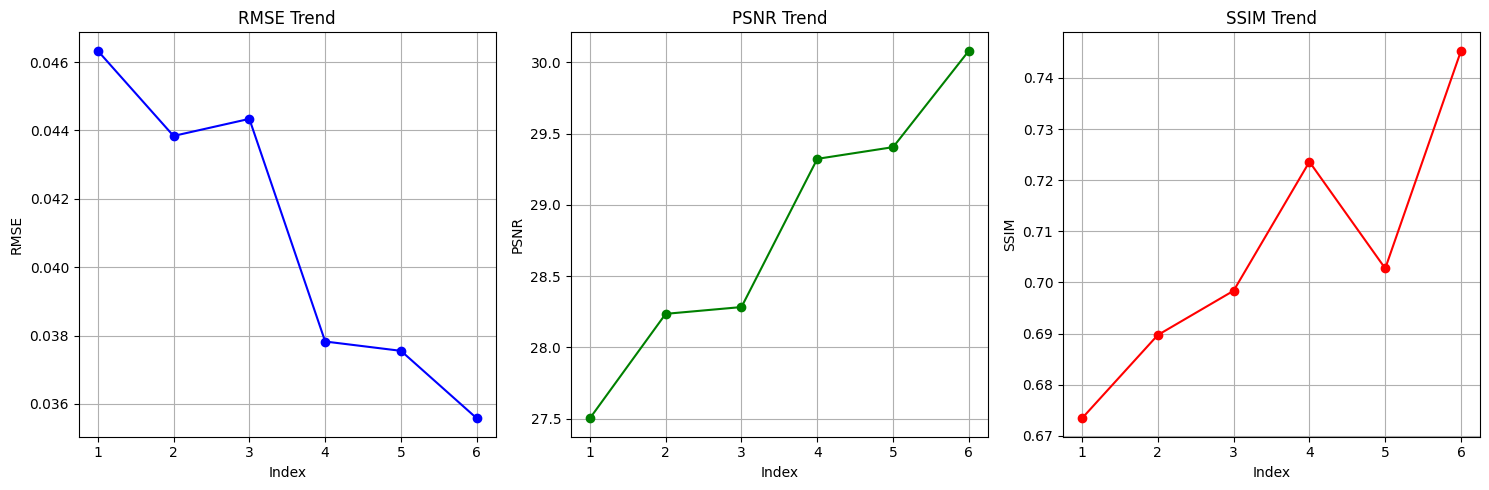

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# 그래프 인덱스 (각 값의 순서를 나타냄)
x_values = np.arange(1, 7)

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
axs[0].plot(x_values, rmse_list, marker='o', linestyle='-', color='b', label="RMSE")
axs[0].set_title('RMSE Trend')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('RMSE')
axs[0].grid(True)

# PSNR 그래프
axs[1].plot(x_values, psnr_list, marker='o', linestyle='-', color='g', label="PSNR")
axs[1].set_title('PSNR Trend')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('PSNR')
axs[1].grid(True)

# SSIM 그래프
axs[2].plot(x_values, ssim_list, marker='o', linestyle='-', color='r', label="SSIM")
axs[2].set_title('SSIM Trend')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('SSIM')
axs[2].grid(True)

# 그래프 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

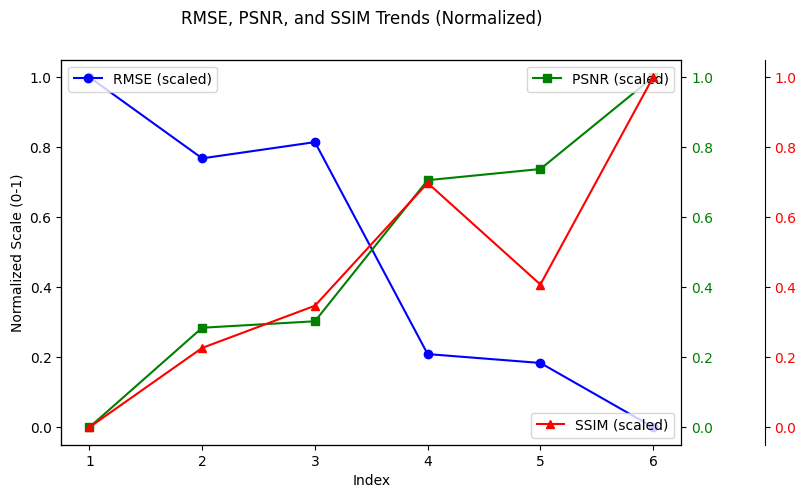

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# 정규화 함수 (min-max scaling)
def min_max_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# 정규화
rmse_scaled = min_max_scale(rmse_list)
psnr_scaled = min_max_scale(psnr_list)
ssim_scaled = min_max_scale(ssim_list)

# 그래프 인덱스
x_values = np.arange(1, len(rmse_list) + 1)

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(8, 5))

# RMSE (파란색 원)
ax1.plot(x_values, rmse_scaled, marker='o', linestyle='-', color='b', label="RMSE (scaled)")
ax1.set_ylabel("Normalized Scale (0-1)", color='black')
ax1.set_xlabel("Index")
ax1.tick_params(axis='y', labelcolor='black')

# PSNR (초록색 사각형, 보조 y축)
ax2 = ax1.twinx()
ax2.plot(x_values, psnr_scaled, marker='s', linestyle='-', color='g', label="PSNR (scaled)")
ax2.tick_params(axis='y', labelcolor='g')

# SSIM (빨간색 삼각형, 추가 y축)
ax3 = ax1.twinx()
ax3.plot(x_values, ssim_scaled, marker='^', linestyle='-', color='r', label="SSIM (scaled)")
ax3.spines['right'].set_position(("outward", 60))  # 세 번째 y축을 오른쪽 바깥으로 조정
ax3.tick_params(axis='y', labelcolor='r')

# 제목 및 범례
fig.suptitle("RMSE, PSNR, and SSIM Trends (Normalized)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax3.legend(loc="lower right")

# 그래프 표시
plt.show()

In [42]:
# 평균(mean)과 표준편차(sd) 계산
rmse_mean = np.mean(rmse_list)
rmse_sd = np.std(rmse_list)

psnr_mean = np.mean(psnr_list)
psnr_sd = np.std(psnr_list)

ssim_mean = np.mean(ssim_list)
ssim_sd = np.std(ssim_list)

# 결과를 mean ± sd 형식으로 표현
rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# 결과 출력
print(f"RMSE: {rmse_result}")
print(f"PSNR: {psnr_result}")
print(f"SSIM: {ssim_result}")

RMSE: 0.0409 ± 0.0041
PSNR: 28.8051 ± 0.8715
SSIM: 0.7055 ± 0.0233


# 1-3. REDCNN with S.A.

In [43]:
!pwd

/content/drive/MyDrive/attention_channel


In [44]:
%cd /content/drive/MyDrive/attention_spatial

/content/drive/MyDrive/attention_spatial


In [45]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [46]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2 # 동일한 크기를 유지하기 위한 패딩
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.last_attention = None  # Attention 값을 저장하는 변수

    def forward(self, x):
        # 채널 차원을 압축 (Max Pooling과 Average Pooling)
        avg_out = torch.mean(x, dim=1, keepdim=True) # Average pooling
        max_out, _ = torch.max(x, dim=1, keepdim=True) # Max pooling
        combined = torch.cat([avg_out, max_out], dim=1) # 채널 차원에서 결합
        # 2D Convolution 적용
        attention = self.sigmoid(self.conv(combined)) # [B, 1, H, W]
        self.last_attention = attention  # Attention 값을 저장
        return x * attention

In [47]:
class RedCNNWithSpatialAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithSpatialAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Spatial Attention Blocks
        self.spatial_attention3 = SpatialAttention()
        self.spatial_attention5 = SpatialAttention()

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.spatial_attention3(x)  # Spatial Attention (3번째 위치)
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.spatial_attention5(x)  # Spatial Attention (5번째 위치)

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [48]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithSpatialAttention().to(device)
model.load_state_dict(torch.load('red_cnn_S_A.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1011/6025 [00:14<01:09, 72.36it/s]

RMSE per interval: 0.0465, PSNR per interval: 27.49, SSIM per interval: 0.6757


Evaluating:  33%|███▎      | 2011/6025 [00:27<00:54, 73.92it/s]

RMSE per interval: 0.0438, PSNR per interval: 28.29, SSIM per interval: 0.6916


Evaluating:  50%|████▉     | 3011/6025 [00:41<00:42, 71.73it/s]

RMSE per interval: 0.0442, PSNR per interval: 28.43, SSIM per interval: 0.7004


Evaluating:  67%|██████▋   | 4007/6025 [00:55<00:28, 70.97it/s]

RMSE per interval: 0.0378, PSNR per interval: 29.40, SSIM per interval: 0.7253


Evaluating:  83%|████████▎ | 5007/6025 [01:09<00:14, 71.75it/s]

RMSE per interval: 0.0374, PSNR per interval: 29.53, SSIM per interval: 0.7048


Evaluating: 100%|█████████▉| 6007/6025 [01:23<00:00, 71.88it/s]

RMSE per interval: 0.0353, PSNR per interval: 30.26, SSIM per interval: 0.7479


Evaluating: 100%|██████████| 6025/6025 [01:23<00:00, 72.23it/s]

Average RMSE over all intervals: 0.040854


In [49]:
len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [50]:
rmse_list = loss_list
rmse_list

[0.04648361468873918,
 0.04384492488950491,
 0.0442211240278557,
 0.03784932059422135,
 0.03741686298791319,
 0.03530783971492201]

In [51]:
!pwd

/content/drive/MyDrive/attention_spatial


In [52]:
# 저장하는 코드

import pandas as pd

# 데이터프레임 생성
df = pd.DataFrame({
    "RMSE": loss_list,
    "PSNR": psnr_list,
    "SSIM": ssim_list
})

# CSV 파일 저장
csv_filename = f"{root}/attention_spatial/results.csv"
df.to_csv(csv_filename, index=False)

print(f"저장 완료: {csv_filename}")

저장 완료: /content/drive/MyDrive/attention_spatial/results.csv


In [53]:
# 불러오는 코드

import pandas as pd

# CSV 파일 불러오기
csv_filename = f"{root}/attention_spatial/results.csv"
df = pd.read_csv(csv_filename)

# 불러온 데이터 출력
print(df,'\n')

# 개별 리스트로 변환
loss_list = df["RMSE"].tolist()
psnr_list = df["PSNR"].tolist()
ssim_list = df["SSIM"].tolist()

# 확인 출력
print("RMSE List:", loss_list)
print("PSNR List:", psnr_list)
print("SSIM List:", ssim_list)

       RMSE       PSNR      SSIM
0  0.046484  27.494712  0.675724
1  0.043845  28.285517  0.691639
2  0.044221  28.428195  0.700411
3  0.037849  29.404645  0.725291
4  0.037417  29.529264  0.704792
5  0.035308  30.262312  0.747893 

RMSE List: [0.0464836146887391, 0.0438449248895049, 0.0442211240278557, 0.0378493205942213, 0.0374168629879131, 0.035307839714922]
PSNR List: [27.49471156402489, 28.285517480590087, 28.4281951672694, 29.40464499208712, 29.52926400857509, 30.26231191385869]
SSIM List: [0.6757238714011338, 0.6916393438496606, 0.7004109295106904, 0.7252911171765113, 0.7047920253901117, 0.747893183719201]


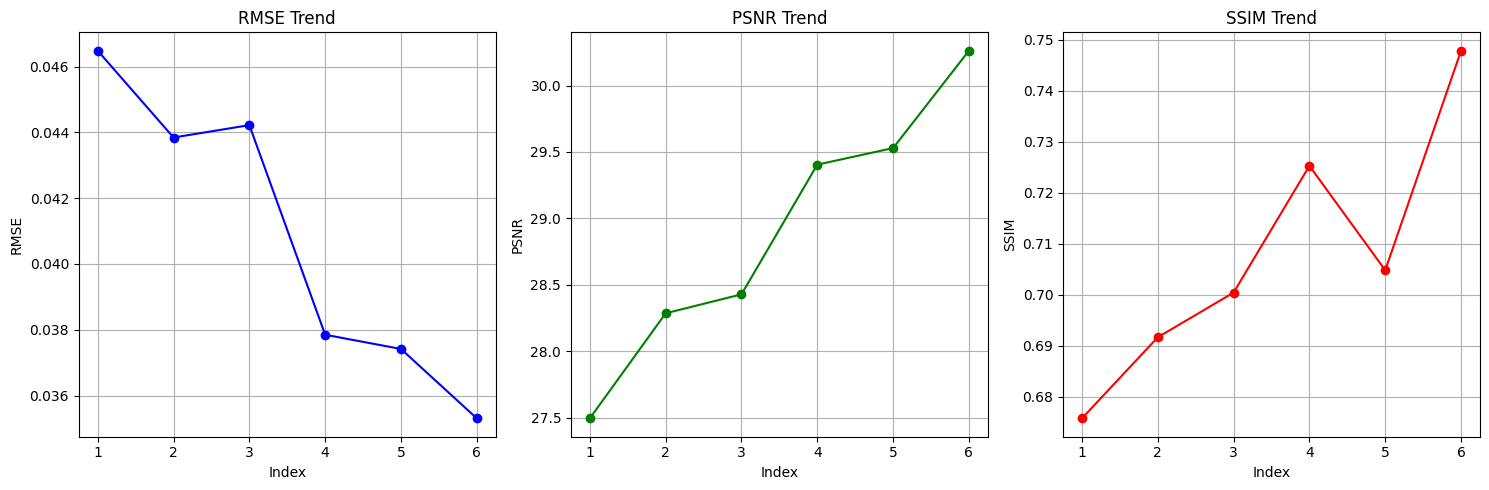

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# 그래프 인덱스 (각 값의 순서를 나타냄)
x_values = np.arange(1, 7)

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
axs[0].plot(x_values, rmse_list, marker='o', linestyle='-', color='b', label="RMSE")
axs[0].set_title('RMSE Trend')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('RMSE')
axs[0].grid(True)

# PSNR 그래프
axs[1].plot(x_values, psnr_list, marker='o', linestyle='-', color='g', label="PSNR")
axs[1].set_title('PSNR Trend')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('PSNR')
axs[1].grid(True)

# SSIM 그래프
axs[2].plot(x_values, ssim_list, marker='o', linestyle='-', color='r', label="SSIM")
axs[2].set_title('SSIM Trend')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('SSIM')
axs[2].grid(True)

# 그래프 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

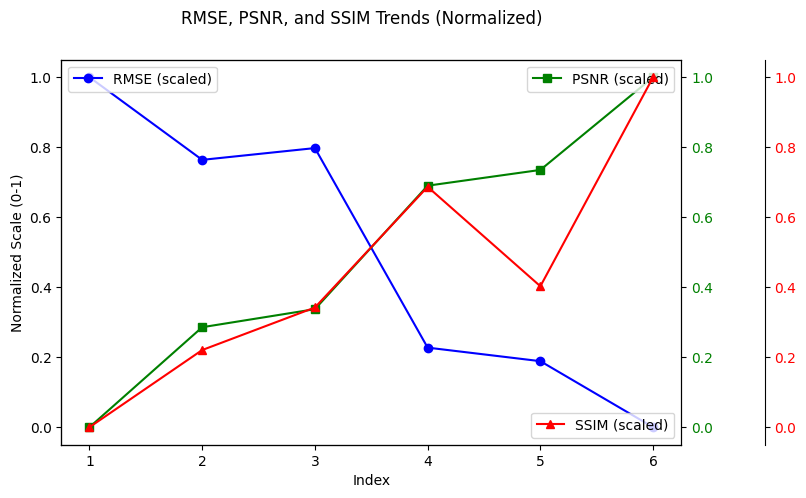

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# 정규화 함수 (min-max scaling)
def min_max_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# 정규화
rmse_scaled = min_max_scale(rmse_list)
psnr_scaled = min_max_scale(psnr_list)
ssim_scaled = min_max_scale(ssim_list)

# 그래프 인덱스
x_values = np.arange(1, len(rmse_list) + 1)

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(8, 5))

# RMSE (파란색 원)
ax1.plot(x_values, rmse_scaled, marker='o', linestyle='-', color='b', label="RMSE (scaled)")
ax1.set_ylabel("Normalized Scale (0-1)", color='black')
ax1.set_xlabel("Index")
ax1.tick_params(axis='y', labelcolor='black')

# PSNR (초록색 사각형, 보조 y축)
ax2 = ax1.twinx()
ax2.plot(x_values, psnr_scaled, marker='s', linestyle='-', color='g', label="PSNR (scaled)")
ax2.tick_params(axis='y', labelcolor='g')

# SSIM (빨간색 삼각형, 추가 y축)
ax3 = ax1.twinx()
ax3.plot(x_values, ssim_scaled, marker='^', linestyle='-', color='r', label="SSIM (scaled)")
ax3.spines['right'].set_position(("outward", 60))  # 세 번째 y축을 오른쪽 바깥으로 조정
ax3.tick_params(axis='y', labelcolor='r')

# 제목 및 범례
fig.suptitle("RMSE, PSNR, and SSIM Trends (Normalized)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax3.legend(loc="lower right")

# 그래프 표시
plt.show()

In [56]:
# 평균(mean)과 표준편차(sd) 계산
rmse_mean = np.mean(rmse_list)
rmse_sd = np.std(rmse_list)

psnr_mean = np.mean(psnr_list)
psnr_sd = np.std(psnr_list)

ssim_mean = np.mean(ssim_list)
ssim_sd = np.std(ssim_list)

# 결과를 mean ± sd 형식으로 표현
rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# 결과 출력
print(f"RMSE: {rmse_result}")
print(f"PSNR: {psnr_result}")
print(f"SSIM: {ssim_result}")

RMSE: 0.0409 ± 0.0042
PSNR: 28.9008 ± 0.9203
SSIM: 0.7076 ± 0.0233


# 2. moanet

## 데이터셋 불러오기

In [58]:
import pandas as pd

# organ_probs.csv 파일 불러오기
organ_probs_df = pd.read_csv(f"{root}/organ_probs.csv")
organ_probs_df.head(1)

,File_Path,skull,ventricles,lungs,mediastinum,liver,kidneys,pancreas,spleen,abdominal aorta,spine,lymph nodes
0,/content/drive/MyDrive/mayo2016/L067/quarter_1...,2.140607e-08,0.00043,0.978917,0.018699,0.000021,0.000003,0.000001,0.001919,2.020908e-07,0.000009,7.648957e-07


In [59]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list, organ_probs_df):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.organ_probs_df = organ_probs_df
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir # 리스트 + 리스트 = 리스트
            y_dir_list += y_dir

        for i, (X_dir, y_dir) in tqdm(enumerate(zip(X_dir_list, y_dir_list)), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            organ_prob = torch.tensor([float(v) for v in organ_probs_df.iloc[i, 1:].values], dtype=torch.float32) # organ_prob을 tensor로 변환

            for j in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[j]).float(), torch.from_numpy(y_patches[j]).float() # torch로 넣어주자.
                self.image_pairs.append((X_patch, organ_prob, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)

        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = (self.image_pairs[idx][0], self.image_pairs[idx][1])
        y = self.image_pairs[idx][2]
        return X, y

In [62]:
# 파일 경로 설정

folder_name = f'{root}/dataset_add_prob/'
test_path = folder_name+'test_dataset.pt'
test_dataset = torch.load(test_path, weights_only=False)

batch_size = 16
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

len(test_loader)

6025

## 평가지표 계산하기

In [63]:
!pwd

/content/drive/MyDrive/attention_spatial


In [64]:
%cd /content/drive/MyDrive/moanet

/content/drive/MyDrive/moanet


In [65]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [66]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7, num_organs=11):  # num_organs = len(text_descriptions)
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2  # 동일한 크기를 유지하기 위한 패딩
        self.conv = nn.Conv2d(2, num_organs, kernel_size=kernel_size, padding=padding, bias=False)  # 장기별 attention
        self.sigmoid = nn.Sigmoid()
        self.last_attention = None  # Attention 값을 저장하는 변수

    def forward(self, x, organ_prob):
        """
        Args:
            x (torch.Tensor): Input feature map [B, C, H, W]
            organ_prob (torch.Tensor): Organ probability vector [B, num_organs]
        Returns:
            torch.Tensor: Attention-weighted feature map [B, C, H, W]
        """

        B, C, H, W = x.shape  # 배치 크기, 채널 수, 높이, 너비

        # 채널 차원을 압축 (Max Pooling과 Average Pooling)
        avg_out = torch.mean(x, dim=1, keepdim=True)  # Average pooling -> [B, 1, H, W]
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # Max pooling -> [B, 1, H, W]
        combined = torch.cat([avg_out, max_out], dim=1)  # [B, 2, H, W]

        # 2D Convolution 적용하여 여러 장기의 attention map 생성
        attention = self.sigmoid(self.conv(combined))  # [B, num_organs, H, W]
        self.last_attention = attention  # Attention 저장

        # organ_prob을 attention과 동일한 차원으로 변환하여 element-wise 곱셈
        organ_prob = organ_prob.view(B, -1, 1, 1)  # [B, num_organs, 1, 1]
        weighted_attention = attention * organ_prob  # [B, num_organs, H, W] 각 장기별 확률 반영

        # 장기별 attention을 합산하여 최종 attention map 생성
        final_attention = torch.sum(weighted_attention, dim=1, keepdim=True)  # [B, 1, H, W]

        # 입력 `x`에 최종 attention을 적용
        output = x * final_attention  # [B, C, H, W]

        return output

In [67]:
class RedCNNWithSpatialAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithSpatialAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Spatial Attention Blocks
        self.spatial_attention3 = SpatialAttention()
        self.spatial_attention5 = SpatialAttention()

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x, prob):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.spatial_attention3(x, prob)  # Spatial Attention (3번째 위치)
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.spatial_attention5(x, prob)  # Spatial Attention (5번째 위치)

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [68]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithSpatialAttention().to(device)
model.load_state_dict(torch.load('red_cnn_S_A.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
        X_hat = model(X, prob)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1013/6025 [00:14<01:11, 70.31it/s]

RMSE per interval: 0.0463, PSNR per interval: 27.51, SSIM per interval: 0.6768


Evaluating:  33%|███▎      | 2013/6025 [00:28<00:59, 67.00it/s]

RMSE per interval: 0.0436, PSNR per interval: 28.31, SSIM per interval: 0.6917


Evaluating:  50%|████▉     | 3011/6025 [00:42<00:42, 70.31it/s]

RMSE per interval: 0.0439, PSNR per interval: 28.47, SSIM per interval: 0.7027


Evaluating:  67%|██████▋   | 4009/6025 [00:57<00:28, 71.24it/s]

RMSE per interval: 0.0375, PSNR per interval: 29.46, SSIM per interval: 0.7290


Evaluating:  83%|████████▎ | 5010/6025 [01:11<00:14, 71.36it/s]

RMSE per interval: 0.0371, PSNR per interval: 29.56, SSIM per interval: 0.7071


Evaluating: 100%|█████████▉| 6014/6025 [01:25<00:00, 71.15it/s]

RMSE per interval: 0.0351, PSNR per interval: 30.27, SSIM per interval: 0.7488


Evaluating: 100%|██████████| 6025/6025 [01:25<00:00, 70.26it/s]

Average RMSE over all intervals: 0.040575


In [69]:
len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [70]:
rmse_list = loss_list
rmse_list

[0.046312880808487535,
 0.043571575678884984,
 0.0438817942738533,
 0.037483127750456334,
 0.037144560715183614,
 0.035057692556642]

In [71]:
!pwd

/content/drive/MyDrive/moanet


In [72]:
# 저장하는 코드

import pandas as pd

# 데이터프레임 생성
df = pd.DataFrame({
    "RMSE": loss_list,
    "PSNR": psnr_list,
    "SSIM": ssim_list
})

# CSV 파일 저장
csv_filename = f"{root}/moanet/results.csv"
df.to_csv(csv_filename, index=False)

print(f"저장 완료: {csv_filename}")

저장 완료: /content/drive/MyDrive/moanet/results.csv


In [73]:
# 불러오는 코드

import pandas as pd

# CSV 파일 불러오기
csv_filename = f"{root}/moanet/results.csv"
df = pd.read_csv(csv_filename)

# 불러온 데이터 출력
print(df,'\n')

# 개별 리스트로 변환
loss_list = df["RMSE"].tolist()
psnr_list = df["PSNR"].tolist()
ssim_list = df["SSIM"].tolist()

# 확인 출력
print("RMSE List:", loss_list)
print("PSNR List:", psnr_list)
print("SSIM List:", ssim_list)

       RMSE       PSNR      SSIM
0  0.046313  27.510207  0.676752
1  0.043572  28.314450  0.691732
2  0.043882  28.465823  0.702722
3  0.037483  29.463024  0.728961
4  0.037145  29.561086  0.707092
5  0.035058  30.272861  0.748846 

RMSE List: [0.0463128808084875, 0.0435715756788849, 0.0438817942738533, 0.0374831277504563, 0.0371445607151836, 0.035057692556642]
PSNR List: [27.510207034741743, 28.31445031163946, 28.465823396358, 29.4630243771445, 29.5610859555675, 30.27286132099729]
SSIM List: [0.6767516288801707, 0.6917320191708122, 0.7027221247999965, 0.728960892307981, 0.707091514669813, 0.7488464246629691]


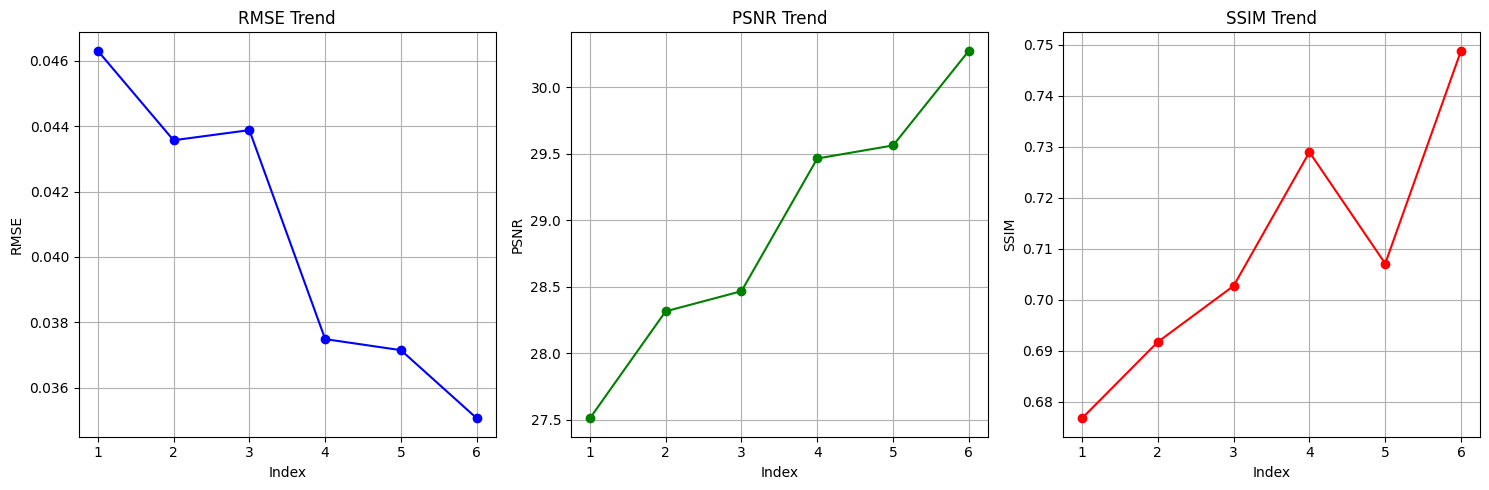

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# 그래프 인덱스 (각 값의 순서를 나타냄)
x_values = np.arange(1, 7)

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
axs[0].plot(x_values, rmse_list, marker='o', linestyle='-', color='b', label="RMSE")
axs[0].set_title('RMSE Trend')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('RMSE')
axs[0].grid(True)

# PSNR 그래프
axs[1].plot(x_values, psnr_list, marker='o', linestyle='-', color='g', label="PSNR")
axs[1].set_title('PSNR Trend')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('PSNR')
axs[1].grid(True)

# SSIM 그래프
axs[2].plot(x_values, ssim_list, marker='o', linestyle='-', color='r', label="SSIM")
axs[2].set_title('SSIM Trend')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('SSIM')
axs[2].grid(True)

# 그래프 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

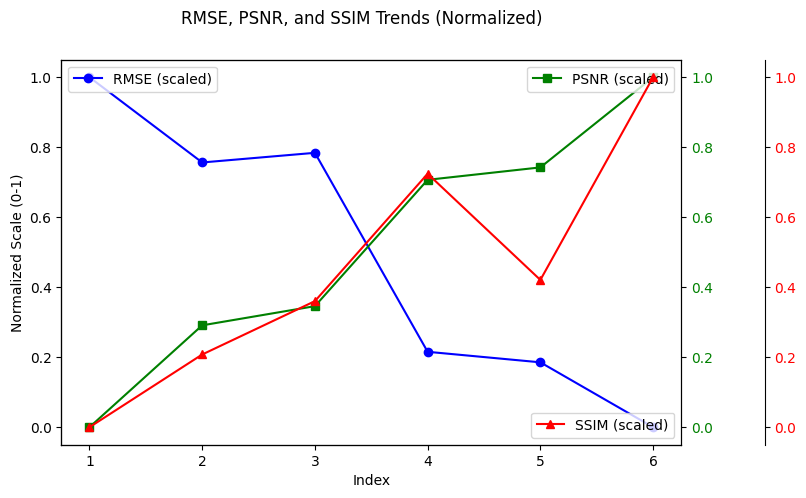

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# 정규화 함수 (min-max scaling)
def min_max_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# 정규화
rmse_scaled = min_max_scale(rmse_list)
psnr_scaled = min_max_scale(psnr_list)
ssim_scaled = min_max_scale(ssim_list)

# 그래프 인덱스
x_values = np.arange(1, len(rmse_list) + 1)

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(8, 5))

# RMSE (파란색 원)
ax1.plot(x_values, rmse_scaled, marker='o', linestyle='-', color='b', label="RMSE (scaled)")
ax1.set_ylabel("Normalized Scale (0-1)", color='black')
ax1.set_xlabel("Index")
ax1.tick_params(axis='y', labelcolor='black')

# PSNR (초록색 사각형, 보조 y축)
ax2 = ax1.twinx()
ax2.plot(x_values, psnr_scaled, marker='s', linestyle='-', color='g', label="PSNR (scaled)")
ax2.tick_params(axis='y', labelcolor='g')

# SSIM (빨간색 삼각형, 추가 y축)
ax3 = ax1.twinx()
ax3.plot(x_values, ssim_scaled, marker='^', linestyle='-', color='r', label="SSIM (scaled)")
ax3.spines['right'].set_position(("outward", 60))  # 세 번째 y축을 오른쪽 바깥으로 조정
ax3.tick_params(axis='y', labelcolor='r')

# 제목 및 범례
fig.suptitle("RMSE, PSNR, and SSIM Trends (Normalized)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax3.legend(loc="lower right")

# 그래프 표시
plt.show()

In [76]:
# 평균(mean)과 표준편차(sd) 계산
rmse_mean = np.mean(rmse_list)
rmse_sd = np.std(rmse_list)

psnr_mean = np.mean(psnr_list)
psnr_sd = np.std(psnr_list)

ssim_mean = np.mean(ssim_list)
ssim_sd = np.std(ssim_list)

# 결과를 mean ± sd 형식으로 표현
rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# 결과 출력
print(f"RMSE: {rmse_result}")
print(f"PSNR: {psnr_result}")
print(f"SSIM: {ssim_result}")

RMSE: 0.0406 ± 0.0042
PSNR: 28.9312 ± 0.9216
SSIM: 0.7094 ± 0.0237


# 최종결과비교

In [79]:
name

'channel'

In [80]:
df_dict[0] = 1

IndexError: list assignment index out of range

In [81]:
import pandas as pd

# CSV 파일 경로 설정
csv_paths = {
    "channel": f"{root}/attention_channel/results.csv",
    "spatial": f"{root}/attention_spatial/results.csv",
    "moanet": f"{root}/moanet/results.csv"
}

# 각 파일을 읽어와서 데이터프레임으로 저장
df_dict = {}
for name, path in csv_paths.items():
    df = pd.read_csv(path)
    df_dict[name] = df
df_dict

{'channel':        RMSE       PSNR      SSIM
 0  0.046331  27.501560  0.673425
 1  0.043838  28.235191  0.689721
 2  0.044337  28.282834  0.698382
 3  0.037825  29.323287  0.723607
 4  0.037552  29.405523  0.702748
 5  0.035577  30.082457  0.745334,
 'spatial':        RMSE       PSNR      SSIM
 0  0.046484  27.494712  0.675724
 1  0.043845  28.285517  0.691639
 2  0.044221  28.428195  0.700411
 3  0.037849  29.404645  0.725291
 4  0.037417  29.529264  0.704792
 5  0.035308  30.262312  0.747893,
 'moanet':        RMSE       PSNR      SSIM
 0  0.046313  27.510207  0.676752
 1  0.043572  28.314450  0.691732
 2  0.043882  28.465823  0.702722
 3  0.037483  29.463024  0.728961
 4  0.037145  29.561086  0.707092
 5  0.035058  30.272861  0.748846}

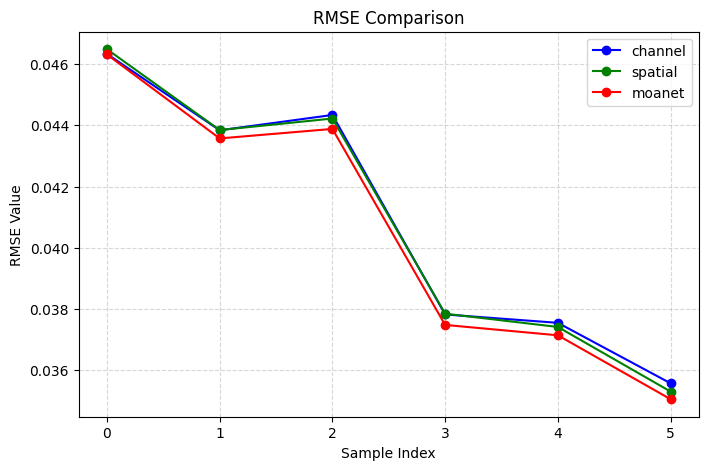

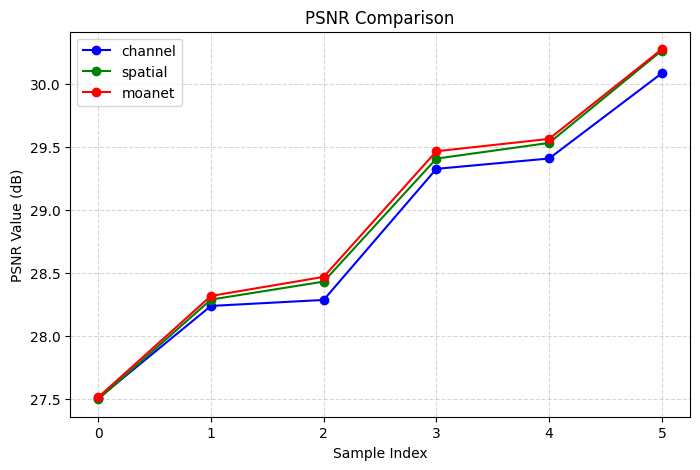

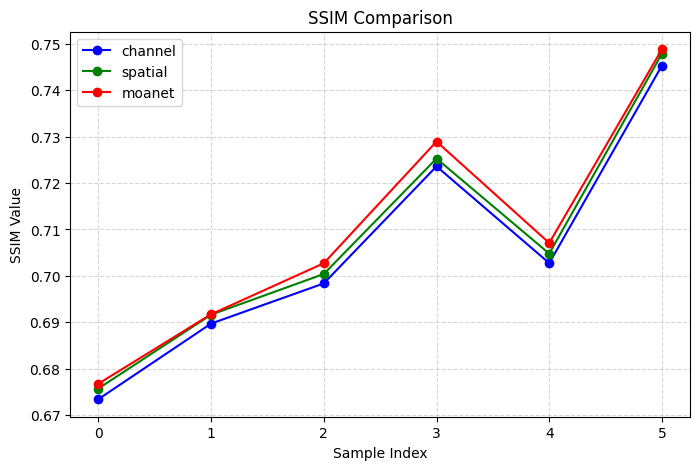

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 리스트
model_names = ["channel", "spatial", "moanet"]
colors = ["b", "g", "r"]  # 각 모델별 색상 지정

# 그래프 그리는 함수
def plot_metric(metric_name, ylabel):
    plt.figure(figsize=(8, 5))  # 그래프 크기 설정

    for model, color in zip(model_names, colors):
        metric_values = df_dict[model][metric_name].values  # 모델별 해당 지표 값 가져오기
        x_axis = np.arange(len(metric_values))  # X축: 데이터 인덱스
        plt.plot(x_axis, metric_values, marker="o", linestyle="-", color=color, label=model)

    plt.xlabel("Sample Index")
    plt.ylabel(ylabel)
    plt.title(f"{metric_name} Comparison")
    plt.legend()  # 모델 구분을 위한 legend 추가
    plt.grid(True, linestyle="--", alpha=0.5)  # 격자 추가
    plt.show()

# RMSE 그래프
plot_metric("RMSE", "RMSE Value")

# PSNR 그래프
plot_metric("PSNR", "PSNR Value (dB)")

# SSIM 그래프
plot_metric("SSIM", "SSIM Value")

<ipython-input-88-1cd2aede18a7>:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right")  # X축 레이블 회전
<ipython-input-88-1cd2aede18a7>:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right")  # X축 레이블 회전
<ipython-input-88-1cd2aede18a7>:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right")  # X축 레이블 회전


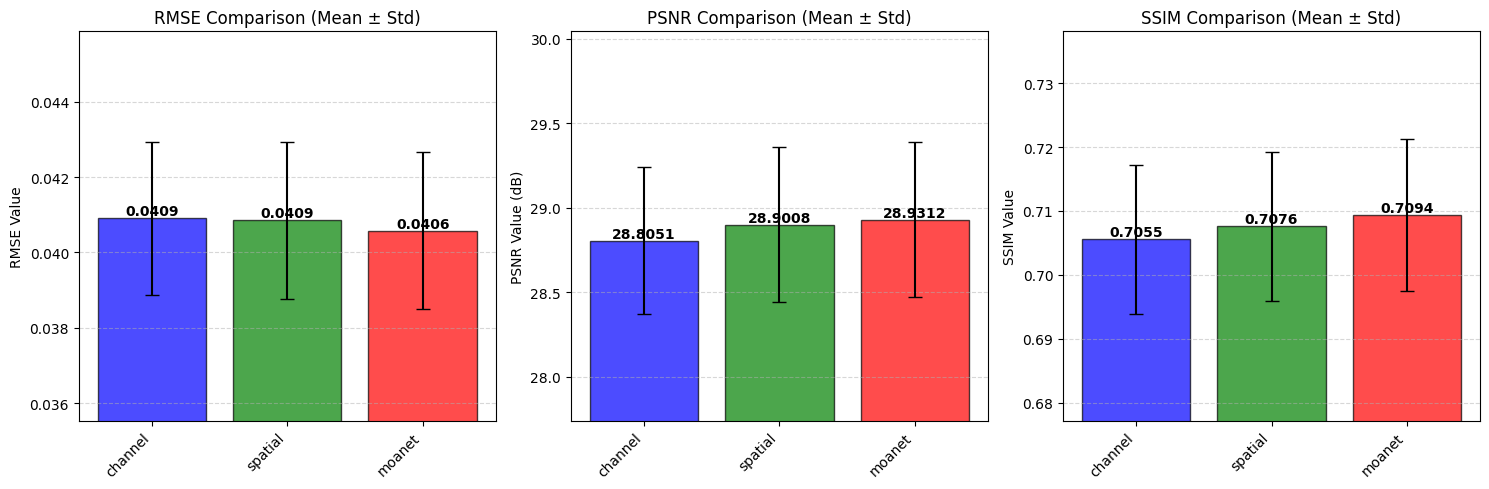

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 리스트 및 색상 설정
model_names = ["channel", "spatial", "moanet"]
colors = ["b", "g", "r"]  # 모델별 색상

# 그래프 그리는 함수 (평균 + 표준편차)
def plot_mean_std(ax, metric_name, ylabel):
    x_labels = model_names  # X축에 모델 이름 표시
    means = []  # 평균값 저장 리스트
    stds = []   # 표준편차 저장 리스트

    for model in model_names:
        metric_values = df_dict[model][metric_name].values  # 해당 모델의 지표 값 가져오기
        means.append(np.mean(metric_values))  # 평균
        stds.append(np.std(metric_values))  # 표준편차

    # 리스트를 NumPy 배열로 변환
    means = np.array(means)
    stds = np.array(stds)

    # y축 범위 설정 (최소/최대값 + 표준편차의 3배)
    ymin = np.min(means-stds)
    ymax = np.max(means+stds)
    ax.set_ylim(ymin, ymax)

    # 막대그래프 (오차 막대 포함)
    bars = ax.bar(x_labels, means, yerr=stds / 2, capsize=5, color=colors, alpha=0.7, edgecolor="black")

    # 막대 위에 평균값 표시
    for bar, mean in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{mean:.4f}",
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    ax.set_xticklabels(x_labels, rotation=45, ha="right")  # X축 레이블 회전
    ax.set_ylabel(ylabel)
    ax.set_title(f"{metric_name} Comparison (Mean ± Std)")
    ax.grid(axis="y", linestyle="--", alpha=0.5)  # y축 격자 추가

# 1행 3열 그래프 생성
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
plot_mean_std(axes[0], "RMSE", "RMSE Value")

# PSNR 그래프
plot_mean_std(axes[1], "PSNR", "PSNR Value (dB)")

# SSIM 그래프
plot_mean_std(axes[2], "SSIM", "SSIM Value")

plt.tight_layout()
plt.show()
